<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/single_variable_scale1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/podobongbong/the_project.git

Cloning into 'the_project'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 131.08 KiB | 7.28 MiB/s, done.


In [7]:
import os
os.chdir('/content/the_project') # Changed directory to where the CSV file likely exists
import pandas as pd

# Updated path to reflect the CSV's location in the cloned repo
data = pd.read_csv('energy.csv')

data.columns = ['year','city','district','type','jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

#일단 총계 데이터만 사용함
data = data[data['type']=='총계']

monthly_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
aggregated_data = data.groupby(['year','city'])[monthly_columns].sum().reset_index()

# Updated path for the output CSV as well
aggregated_data.to_csv('total_aggregated_city_energy.csv', index=False)


In [8]:
#%% DATA PREP
import numpy as np
from sklearn.preprocessing import MinMaxScaler
seoul_data = aggregated_data[aggregated_data['city'] == '서울특별시'].drop(columns=['city']).set_index('year')
busan_data = aggregated_data[aggregated_data['city'] == '부산광역시'].drop(columns=['city']).set_index('year')

energy_data_seoul = seoul_data.values.flatten()
energy_data_busan = busan_data.values.flatten()

# Normalize the data using MinMaxScaler
scaler_seoul = MinMaxScaler()  # Use separate scaler for Seoul
scaler_busan = MinMaxScaler()  # Use separate scaler for Busan
# Normalize Seoul data
energy_data_seoul_scaled = scaler_seoul.fit_transform(energy_data_seoul.reshape(-1, 1)).flatten()

# Normalize Busan data
energy_data_busan_scaled = scaler_busan.fit_transform(energy_data_busan.reshape(-1, 1)).flatten()



In [9]:
#%% SLIDING WINDOW
# Function to create sliding window samples
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Take the previous 'window_size' months
        y.append(data[i])  # The target is the next month's consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 12
TOTAL_MONTHS = 240

# Create sliding window samples for Seoul and Busan
X_seoul, y_seoul = create_sliding_window(energy_data_seoul_scaled, WINDOW_SIZE)
X_busan, y_busan = create_sliding_window(energy_data_busan_scaled, WINDOW_SIZE)

# Split Busan data into training and test sets (hold out the last 12 months for testing)
X_train_busan = X_busan[:-12]
y_train_busan = y_busan[:-12]
X_test_busan = X_busan[-12:]
y_test_busan = y_busan[-12:]


In [17]:
#%% Model creation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape # Import Reshape

# Define the LSTM model structure
def build_model(window_size):
    input_layer = Input(shape=(window_size,), name='Input')
    # Reshape the input to 3D for the LSTM layer
    reshaped_input = Reshape((window_size, 1))(input_layer)
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(reshaped_input)

    # Dense layers for final prediction
    dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
    dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)

    # Output layer for predicting the next month's energy consumption
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Create the LSTM model
model = build_model(WINDOW_SIZE)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
print("Pretraining on Seoul data (2004-2023)...")
history_pretrain = model.fit(X_seoul, y_seoul, epochs=50, batch_size=32, validation_split=0.3)

# Fine-tune the model on Busan's data (train on 2004-2022)
print("Fine-tuning on Busan data (2004-2022)...")
history_finetune = model.fit(X_train_busan, y_train_busan, epochs=50, batch_size=32, validation_split=0.3)



Pretraining on Seoul data (2004-2023)...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0160 - mae: 0.1063 - val_loss: 0.0269 - val_mae: 0.1408
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0149 - mae: 0.1026 - val_loss: 0.0167 - val_mae: 0.1008
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0154 - mae: 0.1019 - val_loss: 0.0233 - val_mae: 0.1311
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0126 - mae: 0.0941 - val_loss: 0.0436 - val_mae: 0.1863
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - mae: 0.0991 - val_loss: 0.0163 - val_mae: 0.1056
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0150 - mae: 0.0970 - val_loss: 0.0331 - val_mae: 0.1597
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126 - mae: 0.0932 - val_loss: 0.0383 - val_mae: 0.1749
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0116 - mae: 0.0880 - val_loss: 0.0108 - val_mae: 0.0861
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [25]:
# Test the model on Busan's test data (2023)
print("Testing on Busan data (2023)...")
test_loss, test_mae = model.evaluate(X_test_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on the test data
predictions = model.predict(X_test_busan)

# Rescale predictions back to the original Busan scale using the Busan-specific scaler
predictions_rescaled = scaler_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Display the rescaled predictions
print("Predictions for Busan (2023):", predictions_rescaled)

# Also compare the rescaled predictions with the actual values
actual_rescaled = scaler_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()
print("Actual values for Busan (2023):", actual_rescaled)


Testing on Busan data (2023)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0106 - mae: 0.0890
Test Loss: 0.010575790889561176, Test MAE: 0.08900301903486252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predictions for Busan (2023): [1.8524270e+09 1.8822566e+09 1.7546141e+09 1.6571204e+09 1.6560133e+09
 1.6323182e+09 1.6865457e+09 1.7737582e+09 1.8136207e+09 1.7120215e+09
 1.6766469e+09 1.7326204e+09]
Actual values for Busan (2023): [1.919106e+09 1.793538e+09 1.660595e+09 1.666780e+09 1.569179e+09
 1.580862e+09 1.703106e+09 1.861438e+09 1.720611e+09 1.565677e+09
 1.596068e+09 1.727741e+09]


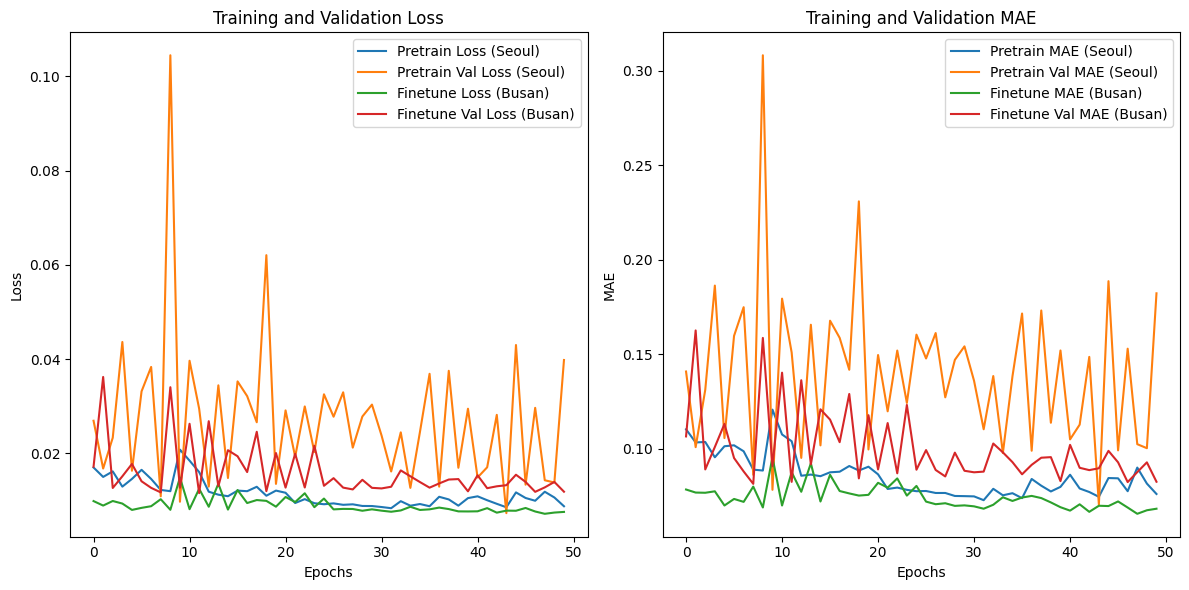

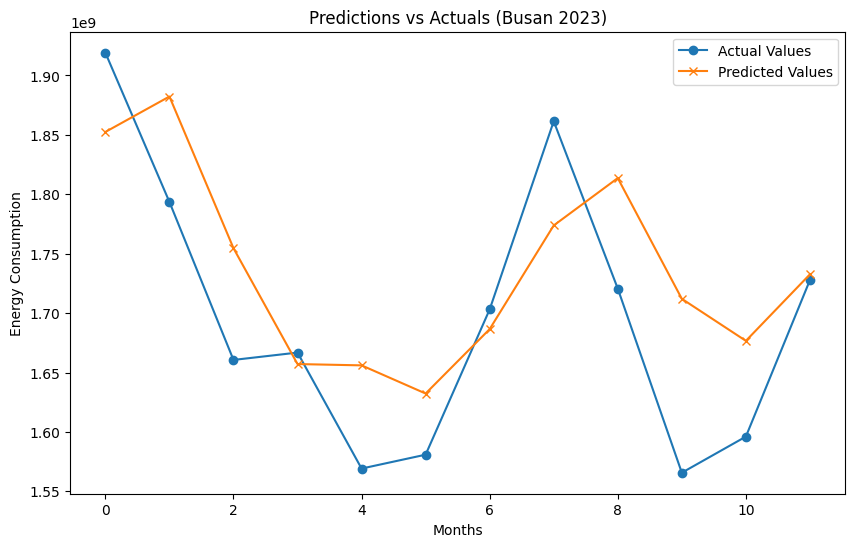

In [26]:
import matplotlib.pyplot as plt

# 1. Plot training and validation loss during pretraining and fine-tuning
def plot_training_history(history_pretrain, history_finetune):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_pretrain.history['loss'], label='Pretrain Loss (Seoul)')
    plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss (Seoul)')
    plt.plot(history_finetune.history['loss'], label='Finetune Loss (Busan)')
    plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss (Busan)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history_pretrain.history['mae'], label='Pretrain MAE (Seoul)')
    plt.plot(history_pretrain.history['val_mae'], label='Pretrain Val MAE (Seoul)')
    plt.plot(history_finetune.history['mae'], label='Finetune MAE (Busan)')
    plt.plot(history_finetune.history['val_mae'], label='Finetune Val MAE (Busan)')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. Plot predictions vs actual values for Busan (2023)
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Call the functions to visualize training and results
plot_training_history(history_pretrain, history_finetune)
plot_predictions(actual_rescaled, predictions_rescaled)
